In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Functions

In [5]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='all'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [6]:
def p_stars(test_pval):
    if test_pval < 0.001:
        return '***'
    elif test_pval < 0.01:
        return '**'
    elif test_pval < 0.05:
        return '*'
    else:
        return 'n.s.'

#### Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [8]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}
c_vermillion = (213/255, 94/255, 0/255)
c_bgreen = (0/255, 158/255, 115/255)
c_skyblue = (86/255, 180/255, 233/255)

### Load subject as EEGexp

In [9]:
recfolder = r'F:\ZZmanuscript_eLife\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1'
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [14]:
test_states = {'awake': [1], 'anesthetized': [2]} # enter sweep number for desired state

### Load eeg data and gather stim-evoked traces

In [15]:
## parameters ##
chtrials = 'all' # choose: 'resting', 'running', or 'all'
apply_car = True

In [16]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()
## Get bad chs ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
## Get stim current ##
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
if len(currents_list) > 1:
    PCI_stim_amp = currents_list[1]
elif len(currents_list) == 1:
    PCI_stim_amp = currents_list[0]
else:
    print('No stim current listed in Zap_Zip-log_exp')

## Load stim log and running signal ##
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})

## Load EEG traces ##
all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

## Get evoked traces ##
EEG_traces = {}
for statei, sweeps in test_states.items():
    if sweeps:
        state_event_inds = []
        for sweepi in sweeps:
            eventinds = get_stim_event_inds(stim_log, 'biphasic', str(PCI_stim_amp), sweepi, trials=chtrials)
            if len(eventinds) == 0:
                continue
            state_event_inds.append(eventinds)
        if len(state_event_inds) == 0:
            continue
        state_event_inds = np.concatenate(state_event_inds)

        ## Get evoked EEG traces ##
        event_traces = all_EEG_traces[:, :, state_event_inds]

        ## Apply common avg ##
        if apply_car:
            event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]

        EEG_traces[statei] = [EEG_event_timestamps, event_traces]

### Plot fig 1C (the array plot with an inset)

Plot awake state only, with all chs (bad = gray), and include the biphasic pulse as an inset

<IPython.core.display.Javascript object>


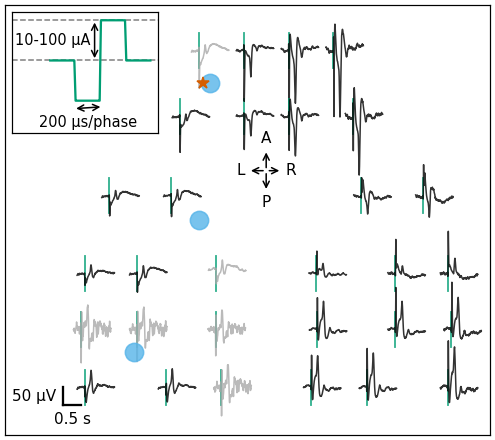

In [18]:
exmouse = '571619'
exgroup = 'MOs_deep'
statei = 'awake'
plwin = [-0.2, 0.8]
xmult = 1.2
ymult = 150 # 250 for VEPs: 100
bregma_ann = {'xycoords': 'data', 'textcoords': 'data', 'arrowprops': dict(arrowstyle='<-', lw=1)}

## Create stim wave for inset ##
xvals = np.arange(-0.2, 0.6, 0.01)
yvals = np.zeros_like(xvals)
yvals[np.nonzero((xvals > 0) & (xvals <= 0.2))[0]] = -1
yvals[np.nonzero((xvals > 0.2) & (xvals <= 0.4))[0]] = 1

fig, ax = plt.subplots(figsize=(4.5, 4), constrained_layout=True)

timex = EEG_traces[statei][0]
traces = np.mean(EEG_traces[statei][1], axis=2)
pinds = np.nonzero((timex >= plwin[0]) & (timex <= plwin[1]))[0]

for chi in range(traces.shape[1]):
    if chi in GOOD_CHS:
        chcolor = 'k'
    else:
        chcolor = 'darkgray'
    if chi == 0:
        llabel = statei
    else:
        llabel = None
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color=c_bgreen, linewidth=1.2, alpha=0.8, label=None)
    ax.plot(
        timex[pinds] + (EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        traces[pinds, chi] + (EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        color=chcolor, linewidth=1.0, alpha=0.8, label=llabel
    )

    if chi == 0:
        mx = timex[0] + EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * 0.85
        my = EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

## Scale bar ##
x_len = .5 # x scale bar length in s
y_len = 50 # y scale bar length in uV
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx+x_len/2,my-y_len*2.25), xycoords='data', ha='center', va='bottom')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx-x_len/3,my-y_len/2), xycoords='data', ha='right', va='center')

## Add symbols for stim, NPXs, and bregma ##
ax.annotate('A', xy=(0,0), xytext=(0,70), ha='center', va='bottom', **bregma_ann)
ax.annotate('P', xy=(0,0), xytext=(0,-70), ha='center', va='top', **bregma_ann)
ax.annotate('L', xy=(0,0), xytext=(-0.8,0), ha='left', va='center', **bregma_ann)
ax.annotate('R', xy=(0,0), xytext=(0.8,0), ha='right', va='center', **bregma_ann)
# ax.plot([-1.5, -1.8, -3.55], [250, -140, -520], marker='X', color='b', linestyle='none')
ax.plot([-1.5, -1.8, -3.55], [250, -140, -520], marker='o', markersize=12, color=c_skyblue, linestyle='none', alpha=0.8)
ax.plot([-1.7], [250], marker='*', color=c_vermillion, markersize=8) #, label='stim')
ax.set_xlim([-7, 6])
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

## Add stim inset ##
axins = inset_axes(ax, width="30%", height="28%", loc=2)
axins.axhline(0, color='gray', linewidth=1, linestyle='dashed')
axins.axhline(1, color='gray', linewidth=1, linestyle='dashed')
axins.plot(xvals, yvals, color=c_bgreen, linewidth=1.5)
axins.set_xlim([-0.5, 0.65])
axins.set_ylim([-1.8, 1.2])
axins.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
axins.annotate('', xy=(0.15, -0.02), xytext=(0.15, 1.02), arrowprops=dict(arrowstyle='<->'))
axins.annotate('10-100 \u03bcA', xy=(0.12, 0.5), ha='right', va='center', annotation_clip=False, fontsize=9.5)
axins.annotate('', xy=(-0.02, -1.2), xytext=(0.22, -1.15), arrowprops=dict(arrowstyle='<->'))
axins.annotate('200 \u03bcs/phase', xy=(0.1, -1.35), ha='center', va='top', annotation_clip=False, fontsize=9.5)

## Save as .png ##
figname = 'Fig1C_{}_{}_{}_{}.png'.format(exgroup, exmouse, statei, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Save as .pdf for Illustrator ##
# fig.savefig(os.path.join(plotsdir, 'AI_pdfs', figname.replace('.png', '.pdf')), transparent=True, dpi=300)

## Supplementary figure about ERP spatial extent

<IPython.core.display.Javascript object>


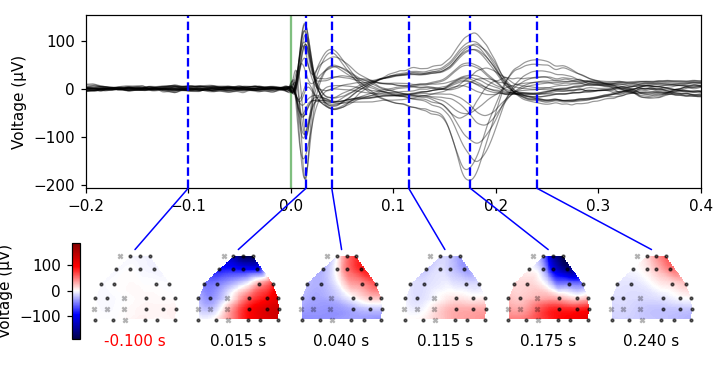

In [19]:
teststate = 'awake'
plwin = [-0.2, 0.4] # window to plot for top plot (s)
plot_times = [-0.1, 0.015, 0.04, 0.115, 0.175, 0.24] # each time point to spatially interpolate (s)

BAD_CHS = np.array([x for x in eeg_chs if x not in GOOD_CHS])
timex = EEG_traces[teststate][0]
traces = np.mean(EEG_traces[teststate][1], axis=2)
vlim = np.max(np.abs(traces[:, GOOD_CHS]))

ml = np.linspace(-5, 5, 100)
ap = np.linspace(-5, 3, 100)
ML, AP = np.meshgrid(ml, ap)

fig = plt.figure(figsize=(6.5, 3.5))
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.12, right=0.98, top=0.96, bottom=0.1, height_ratios=[1.5,1], hspace=0.3)
EEGax = fig.add_subplot(gs[0])
interpgs = gs[1].subgridspec(ncols=len(plot_times), nrows=1, wspace=0.05)
axs = [fig.add_subplot(ss) for ss in interpgs]

EEGax.axvline(0, color='g', alpha=0.5)
EEGax.plot(timex, traces[:, GOOD_CHS], 'k', linewidth=0.8, alpha=0.4)
EEGax.set_xlim(plwin)
EEGax.set_ylabel('Voltage (\u03bcV)')

for ax, timei in zip(axs, plot_times):
    EEGax.axvline(timei, color='b', linestyle='dashed')
    if timei < 0:
        fontc = 'r'
    else:
        fontc = 'k'
    
    interp_EEG = interpolate.griddata(
        (EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS]),
        traces[find_nearest_ind(timex, timei), GOOD_CHS], (ML, AP), method='cubic',
    )
    
    cEEG = ax.imshow(
        interp_EEG, cmap='seismic', vmin=-vlim, vmax=vlim, origin='lower', interpolation='none',
        extent=(ml[0], ml[-1], ap[0], ap[-1])
    )
    ax.scatter(
        EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS],
        c='k', alpha=0.6, marker='o', s=3
    )
    ax.scatter(
        EEGexp.EEG_channel_coordinates['ML'][BAD_CHS], EEGexp.EEG_channel_coordinates['AP'][BAD_CHS],
        c='k', alpha=0.3, marker='x', s=8
    )
#     ax.scatter(0, 0, marker='+', color='k', s=15, alpha=0.3) # bregma marker
    ax.set_xlabel('{:.3f} s'.format(timei), color=fontc)
    ax.set(frame_on=False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ## Make connecting line ##
    con = ConnectionPatch(
        xyA=[timei, EEGax.get_ylim()[0]], xyB=[0.5, 1], coordsA='data', coordsB='axes fraction',
        axesA=EEGax, axesB=ax, color='b'
    )
    ax.add_artist(con)

cbax = fig.add_axes([0.1, 0.12, 0.012, 0.25])
fig.colorbar(cEEG, cax=cbax, ticklocation='left', label='Voltage (\u03bcV)')

## Save ##
figname = 'SuppFig1.1_EEG_spatialinterp.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Save as .pdf for Illustrator ##
# fig.savefig(os.path.join(plotsdir, 'AI_pdfs', figname.replace('.png', '.pdf')), transparent=True, dpi=300)